# Data Mining Final Group Project

In [48]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats.contingency import crosstab
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import aic
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [12]:
df = pd.read_csv("survey_results_public.csv")

The following code drops rows with null values, cleans the data a bit to make mostly-numeric columns all numeric, and separates numerical from categorical variables for analysis and feature selection.

In [13]:
print("Rows with nulls:", df['Hobbyist'].isna().sum())            # relatively few nulls (45)
df = df.dropna(how='any', subset='Hobbyist')  # drop all rows in the response var col without values

print("Total Columns:", df.columns.size)

# categorical columns
cat_vars = df.drop(['Respondent', 
                    'Age', 
                    'Age1stCode',
                    'CompTotal', 
                    'ConvertedComp',
                    'WorkWeekHrs',
                    'YearsCode',
                    'YearsCodePro'], 
                    axis=1)

# conversion to make these a quanititative var
df['YearsCode'].replace('Less than 1 year', 0.5, inplace=True) 
df['YearsCode'].replace('More than 50 years', 55, inplace=True)  # it's unlikely they coded for more than 60 years
df['YearsCodePro'].replace('Less than 1 year', 0.5, inplace=True) 
df['YearsCodePro'].replace('More than 50 years', 55, inplace=True) # it's unlikely they coded pro for more than 60 years

# true values unlikely to be far from these replacements
df['Age1stCode'].replace('Younger than 5 years', 3, inplace=True)  
df['Age1stCode'].replace('Older than 85', 87, inplace=True)  

# quantitative columns
quant_vars = df.filter(['Age',
                        'Age1stCode',
                        'CompTotal',
                        'ConvertedComp',
                        'WorkWeekHrs',
                        'YearsCode',
                        'YearsCodePro'],
                        axis=1)

# for some reason, the data is all of type 'object', not strings or floats, so these convert it
cat_vars = pd.DataFrame(cat_vars, dtype=str)  
quant_vars = pd.DataFrame(quant_vars, dtype=float)

Rows with nulls: 45
Total Columns: 61


## Variable selection

61 columns is a lot of features! We obviously don't want this many. So, to slim down the features further, we can exclude categorical features with very high numbers of levels, since these won't really work well in a machine learning model. So let's see the number of unique values for each categorical feature:

### Categorical variable selection

In [14]:
# count number of levels on each categorical column, drop ones with high number of levels
# sorted for convenience
col_unique_counts = cat_vars.nunique(dropna=True).sort_values(axis=0, ascending=True)
print(col_unique_counts)

Hobbyist                            2
Trans                               3
NEWOtherComms                       3
NEWDevOps                           4
CompFreq                            4
SurveyLength                        4
SurveyEase                          4
NEWOffTopic                         4
NEWOnboardGood                      4
SOAccount                           4
PurchaseWhat                        4
JobSeek                             4
NEWLearn                            5
OpSys                               5
NEWPurpleLink                       5
JobSat                              6
NEWDevOpsImpt                       6
NEWEdImpt                           6
NEWOvertime                         6
MainBranch                          6
SOComm                              7
SOPartFreq                          7
SOVisitFreq                         7
WelcomeChange                       7
Gender                              8
Employment                          8
EdLevel     

Some of these variables have hundreds or even thousands of levels! Looks like we can drop about everything after `Sexuality` (and even keeping up to that may be a bit much).

In [15]:
# categorical variables with smaller number of levels up to the Sexuality column
small_cats = col_unique_counts.loc[:'Sexuality'] 

# reduce columns
cat_vars = cat_vars[small_cats.index]
cat_vars.columns

Index(['Hobbyist', 'Trans', 'NEWOtherComms', 'NEWDevOps', 'CompFreq',
       'SurveyLength', 'SurveyEase', 'NEWOffTopic', 'NEWOnboardGood',
       'SOAccount', 'PurchaseWhat', 'JobSeek', 'NEWLearn', 'OpSys',
       'NEWPurpleLink', 'JobSat', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWOvertime',
       'MainBranch', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'WelcomeChange',
       'Gender', 'Employment', 'EdLevel', 'OrgSize', 'UndergradMajor',
       'Sexuality'],
      dtype='object')

Now we can compare each categorical variable against each other to see if which categorical variables are independent of which (if any). We'll be using $\chi ^2$ tests of independence here, the equivalent of multicolinearity tests for categorical variables. can only select variables that are indeendent of each other, or else we get multicollinearity in the model. Depending on the model, multicolinearity can result in anything from redundancy between features to misleading model results and violation of assumptions. So either way, we can use this test to eliminate features.

In [7]:
# this codeblock takes about 45s to run on my (slow) machine
# it simply conducts the tests and saves the results

chi_sq_tests = np.zeros((len(cat_vars.columns),len(cat_vars.columns)))

for i, rows in enumerate(cat_vars.columns):
    for j, cols in enumerate(cat_vars.columns):
        
        ctab_result = crosstab(cat_vars[rows], cat_vars[cols],
                               levels=(
                                   cat_vars[rows].unique(),
                                   cat_vars[cols].unique()))

        test_results = stats.chi2_contingency(ctab_result[1])
        chi_sq_tests[i][j] = test_results[1]  # load p-values into the grid
        amount_completed = 100*((len(cat_vars.columns)*i + j + 1)/len(cat_vars.columns)**2)
        print(" row:", i, 
              "col:", j, 
              "Progress: {:.2f}%".format(amount_completed),
              end="\r")  # progress

Now we can see our results. The following code scans for test results with a 

In [12]:
# redefine as a DataFrame, to have labels
chi_sq_tests = pd.DataFrame(chi_sq_tests, 
                            columns=cat_vars.columns, 
                            index=cat_vars.columns)
round(chi_sq_tests,2).to_csv('chi_sq_tests.csv')    # to save for later

indep_vars = chi_sq_tests.gt(0.05)           # show which cells in are greater than p=0.05, null not rejected
print(chi_sq_tests[indep_vars].count())      # count all rows in each col where indep_vars == True

Hobbyist          0
Trans             0
NEWOtherComms     0
NEWDevOps         0
CompFreq          0
SurveyLength      0
SurveyEase        0
NEWOffTopic       0
NEWOnboardGood    0
SOAccount         0
PurchaseWhat      0
JobSeek           0
NEWLearn          0
OpSys             0
NEWPurpleLink     0
JobSat            0
NEWDevOpsImpt     0
NEWEdImpt         0
NEWOvertime       0
MainBranch        0
SOComm            0
SOPartFreq        0
SOVisitFreq       0
WelcomeChange     0
Gender            0
Employment        0
EdLevel           0
OrgSize           0
UndergradMajor    0
Sexuality         0
dtype: int64


No row had any $\chi^2$ test result greater than $p = 0.05$. This means no two variables are independent of each other. So we could use exactly 1 categorical variable, but not another one, since we'd run into multicolinearity issues with two or more.

So which one to select?  We should probably select one that doesn't have a lot of levels; I'd say no more than 7. Let's filter out the categoricals with more than 7 levels: 

In [16]:
smallest_cats = cat_vars.loc[:,col_unique_counts <= 7].columns  # smallest categorical variables (index, NOT df)
smallest_cats = smallest_cats.drop(['Hobbyist'])                # we should take out our target too
print(smallest_cats)

Index(['Trans', 'NEWOtherComms', 'NEWDevOps', 'CompFreq', 'SurveyLength',
       'SurveyEase', 'NEWOffTopic', 'NEWOnboardGood', 'SOAccount',
       'PurchaseWhat', 'JobSeek', 'NEWLearn', 'OpSys', 'NEWPurpleLink',
       'JobSat', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWOvertime', 'MainBranch',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'WelcomeChange'],
      dtype='object')


Several of these question topics have to do with the subject's company, their job description, pay frequency, or the survey itself, and as such do not help clarify the individual's personality. I've taken these and listed them in the `irrelevant` list below, and removed them from our list of categorical variables.

In [17]:
irrelevant = ['NEWDevOps', 'CompFreq', 'SurveyLength', 'SurveyEase', 
              'NEWOnboardGood','PurchaseWhat', 'NEWDevOpsImpt']
smallest_cats = smallest_cats.drop(irrelevant)
print(smallest_cats)

Index(['Trans', 'NEWOtherComms', 'NEWOffTopic', 'SOAccount', 'JobSeek',
       'NEWLearn', 'OpSys', 'NEWPurpleLink', 'JobSat', 'NEWEdImpt',
       'NEWOvertime', 'MainBranch', 'SOComm', 'SOPartFreq', 'SOVisitFreq',
       'WelcomeChange'],
      dtype='object')


If this is to be a tool for employers, we probably shouldn't select a variable that uses a legally protected characteristic like `Trans`. Let's drop that one too. 

In [18]:
smallest_cats = smallest_cats.drop(['Trans'])
print(smallest_cats)

Index(['NEWOtherComms', 'NEWOffTopic', 'SOAccount', 'JobSeek', 'NEWLearn',
       'OpSys', 'NEWPurpleLink', 'JobSat', 'NEWEdImpt', 'NEWOvertime',
       'MainBranch', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'WelcomeChange'],
      dtype='object')


I don't see any here that I know I can discount as irrelevant to whether someone taking the survey is a programming hobbyist or not, so we'll leave all these for now and use a gridsearch on a set of logistic regressions, each with all the numerical variables we've chosen and one of the above categorical variables. That will tell us which one was the best choice.

### Numerical variable selection

Now we can take a look at our numerical variables, and see which ones are correlated with each other. If two variables are significantly correlated, we should not include both. The cutoff I chose is $r = 0.6$; correlations higher than that are deemed significant, with ones lower than that insignificant. So let's see what we get:

<Axes: >

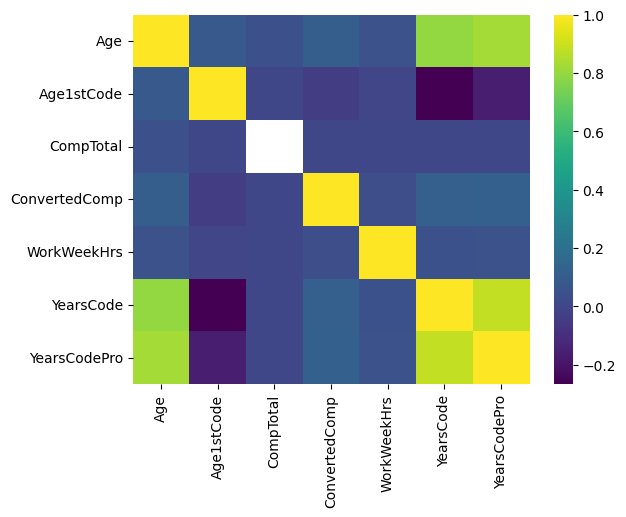

In [59]:
corr_matrix = quant_vars.corr(numeric_only=True)
sns.heatmap(corr_matrix, cmap='viridis')

It looks like `Age` is correlated with `YearsCode` as well as `YearsCodePro` (this seems intuitive). `YearsCode` and `YearsCodePro` are correlated with each other too, so we should only choose one of the three. The rest aren't really correlated. Since `YearsCode` (years the person has been coding) seems most relevant to whether the person is a hobbyist or not, let's keep that one, and drop the other two: 

In [19]:
quant_vars = quant_vars.drop(['Age','YearsCodePro'], axis=1)

Further, `CompTotal` is the total compensation in the survey-taker's native currency, whereas `ConvertedComp` is the salary in USD (using the exchange rate at the time of the survey and 50 working weeks in a year). So `CompTotal` is redundant, if not useless on its own across several currencies. So we'll drop that one too.

In [46]:
quant_vars = quant_vars.drop(['CompTotal'], axis=1)

Now we have our variables narrowed down to something reasonable! To recap, here are our numerical variables, and our candidate categorcal variables:

In [47]:
print("Numerical Variables:\n", quant_vars.columns)
print("\nCategorical Variables:\n", smallest_cats)

Numerical Variables:
 Index(['Age1stCode', 'ConvertedComp', 'WorkWeekHrs', 'YearsCode'], dtype='object')

Categorical Variables:
 Index(['NEWOtherComms', 'NEWOffTopic', 'SOAccount', 'JobSeek', 'NEWLearn',
       'OpSys', 'NEWPurpleLink', 'JobSat', 'NEWEdImpt', 'NEWOvertime',
       'MainBranch', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'WelcomeChange'],
      dtype='object')


## Model Building

### Check for imbalance in target variable

We should probably check for imbalance in the target variable (`Hobbyist`) before we get too much further. Let's see how our data is on that front:

Yes    50388
No     14028
Name: Hobbyist, dtype: int64

No's percent of target: 21.8%
Yes/No ratio: 3.592


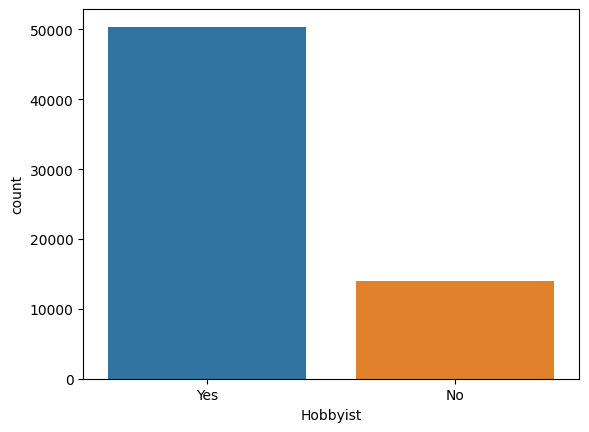

In [45]:
y_n_vals = df.Hobbyist.value_counts()
sns.countplot(df, x='Hobbyist')

print(y_n_vals)
print("\nNo's percent of target: {:.1f}%".format(100*y_n_vals[1]/df.Hobbyist.count()))
print("Yes/No ratio: {:.3f}".format(y_n_vals[0]/y_n_vals[1]))

So there is some imbalance, but it is relatively mild for this dataset (21% minor class, or less than 4:1 major/minor). Further, for logistic regression, balance is less of an issue than having proper sample sizes for each class, which we do, even for the smaller 'no' class ($n_\text{no}=14028$). So we probably have an accurate representation of the distribution of each. In light of that, we won't scale our data here.

### Search for best categorical variable

On to model building proper. Since we don't know which categorical variable will be best for our model, and we have few enough useable quantitative variables to use all of them with each categorical one. That means we'll need check each one to find the best. We'll see if we can pare down the quanititative variables afterward.

In [62]:
# this block is having datatype issues, will resolve later

df.Hobbyist.replace({'Yes': 1, 'No': 0}, inplace=True)
print(df.Hobbyist)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

x_var_combos = [['Age1stCode', 'ConvertedComp', 'WorkWeekHrs', 'YearsCode']
                + [cat] for cat in smallest_cats]

logistic_models = []
for combo in x_var_combos:
    model = sm.Logit(endog=train_data['Hobbyist'], exog=train_data[combo])
    model.fit()
    logistic_models.append(model)

0        1
1        0
2        1
3        1
4        1
        ..
64456    1
64457    1
64458    1
64459    1
64460    1
Name: Hobbyist, Length: 64416, dtype: int64


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and Age1stCode        object
ConvertedComp    float64
WorkWeekHrs      float64
YearsCode         object
NEWOtherComms     object
dtype: object. The data was
31999    0
44025    1
8677     1
14543    0
31804    1
        ..
62610    1
38170    1
860      1
15795    0
56459    1
Name: Hobbyist, Length: 51532, dtype: int64
and
       Age1stCode  ConvertedComp  WorkWeekHrs YearsCode NEWOtherComms
31999         13            NaN         45.0        39            No
44025         19        91883.0         45.0        18            No
8677          20            NaN          NaN         4           Yes
14543         15        50806.0         40.0         9            No
31804         14        39996.0         32.0        25           Yes
...          ...            ...          ...       ...           ...
62610         11            NaN          NaN        13           NaN
38170         10            NaN         35.0        23           NaN
860           18       110000.0         40.0         9            No
15795         13        60989.0         34.0         6            No
56459         13            NaN         40.0        17           Yes

[51532 rows x 5 columns]
before. After,
[0 1 1 ... 1 0 1]
[['13' nan 45.0 '39' 'No']
 ['19' 91883.0 45.0 '18' 'No']
 ['20' nan nan '4' 'Yes']
 ...
 ['18' 110000.0 40.0 '9' 'No']
 ['13' 60989.0 34.0 '6' 'No']
 ['13' nan 40.0 '17' 'Yes']].

In [ ]:
# this code assesses the model
residual_deviance = result.deviance
degrees_of_freedom_residual = result.df_resid

# Calculate the p-value using the survival function (sf) for the chi-square distribution
p_value = chi2.sf(residual_deviance, degrees_of_freedom_residual)

print(f"Goodness-of-fit test p-value: {p_value}")